# ARIMA

In [60]:
import pandas as pd
import matplotlib as mp
from pandas.plotting import autocorrelation_plot

from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np
#from numpy import log
import re
from tqdm import tqdm
import datetime as datetime
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [38]:
df_train = pd.read_csv('../../data/splits/2017/bpi2017_train.csv', parse_dates = ['time:timestamp'])
df_test = pd.read_csv('../../data/splits/2017/bpi2017_test.csv', parse_dates = ['time:timestamp'])
df_val = pd.read_csv('../../data/splits/2017/bpi2017_val.csv', parse_dates = ['time:timestamp'])

Load the datasets, sort them on case and consequently timestamp, then reset the index:

In [39]:
df_train = df_train.sort_values(by = ['case:concept:name', 'time:timestamp']).reset_index()
df_val = df_val.sort_values(by = ['case:concept:name', 'time:timestamp']).reset_index()
df_test = df_test.sort_values(by = ['case:concept:name', 'time:timestamp']).reset_index()

# Remove obsolete columns
df_train = df_train.drop(['index', 'Unnamed: 0'], axis = 1)
df_val = df_val.drop(['index', 'Unnamed: 0'], axis = 1)
df_test = df_test.drop(['index', 'Unnamed: 0'], axis = 1)

In [40]:
df_train.head()

,Action,org:resource,concept:name,EventOrigin,EventID,lifecycle:transition,time:timestamp,case:LoanGoal,case:ApplicationType,case:concept:name,case:RequestedAmount,FirstWithdrawalAmount,NumberOfTerms,Accepted,MonthlyCost,Selected,CreditScore,OfferedAmount,OfferID
0,Created,User_1,A_Create Application,Application,Application_1000086665,complete,2016-08-03 15:57:21.673000+00:00,"Other, see explanation",New credit,Application_1000086665,5000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,statechange,User_1,A_Submitted,Application,ApplState_161925113,complete,2016-08-03 15:57:21.734000+00:00,"Other, see explanation",New credit,Application_1000086665,5000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Created,User_1,W_Handle leads,Workflow,Workitem_747707399,schedule,2016-08-03 15:57:21.963000+00:00,"Other, see explanation",New credit,Application_1000086665,5000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Deleted,User_1,W_Handle leads,Workflow,Workitem_1030261128,withdraw,2016-08-03 15:58:28.286000+00:00,"Other, see explanation",New credit,Application_1000086665,5000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Created,User_1,W_Complete application,Workflow,Workitem_1127124826,schedule,2016-08-03 15:58:28.293000+00:00,"Other, see explanation",New credit,Application_1000086665,5000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
# one hot encoding
df_train_f = pd.get_dummies(df_train, columns = ['concept:name'])
df_test_f = pd.get_dummies(df_test, columns = ['concept:name'])

In [42]:
df_train_f.head()

,Action,org:resource,EventOrigin,EventID,lifecycle:transition,time:timestamp,case:LoanGoal,case:ApplicationType,case:concept:name,case:RequestedAmount,...,concept:name_O_Returned,concept:name_O_Sent (mail and online),concept:name_O_Sent (online only),concept:name_W_Assess potential fraud,concept:name_W_Call after offers,concept:name_W_Call incomplete files,concept:name_W_Complete application,concept:name_W_Handle leads,concept:name_W_Shortened completion,concept:name_W_Validate application
0,Created,User_1,Application,Application_1000086665,complete,2016-08-03 15:57:21.673000+00:00,"Other, see explanation",New credit,Application_1000086665,5000.0,...,0,0,0,0,0,0,0,0,0,0
1,statechange,User_1,Application,ApplState_161925113,complete,2016-08-03 15:57:21.734000+00:00,"Other, see explanation",New credit,Application_1000086665,5000.0,...,0,0,0,0,0,0,0,0,0,0
2,Created,User_1,Workflow,Workitem_747707399,schedule,2016-08-03 15:57:21.963000+00:00,"Other, see explanation",New credit,Application_1000086665,5000.0,...,0,0,0,0,0,0,0,1,0,0
3,Deleted,User_1,Workflow,Workitem_1030261128,withdraw,2016-08-03 15:58:28.286000+00:00,"Other, see explanation",New credit,Application_1000086665,5000.0,...,0,0,0,0,0,0,0,1,0,0
4,Created,User_1,Workflow,Workitem_1127124826,schedule,2016-08-03 15:58:28.293000+00:00,"Other, see explanation",New credit,Application_1000086665,5000.0,...,0,0,0,0,0,0,1,0,0,0


# ADF Test

Check if the series is stationary using the ADF test.

In [43]:
df_train_f.describe(include='all')

C:\Users\20203721\AppData\Local\Temp/ipykernel_23736/651533406.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df_train_f.describe(include='all')


,Action,org:resource,EventOrigin,EventID,lifecycle:transition,time:timestamp,case:LoanGoal,case:ApplicationType,case:concept:name,case:RequestedAmount,...,concept:name_O_Returned,concept:name_O_Sent (mail and online),concept:name_O_Sent (online only),concept:name_W_Assess potential fraud,concept:name_W_Call after offers,concept:name_W_Call incomplete files,concept:name_W_Complete application,concept:name_W_Handle leads,concept:name_W_Shortened completion,concept:name_W_Validate application
count,621131,621131,621131,621131,621131,621131,621131,621131,621131,621131.000000,...,621131.000000,621131.000000,621131.000000,621131.000000,621131.000000,621131.000000,621131.000000,621131.000000,621131.000000,621131.000000
unique,5,136,3,621131,7,621109,13,2,16308,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,statechange,User_1,Workflow,Application_1000086665,complete,2016-03-14 10:12:05.125000+00:00,Car,New credit,Application_1219772874,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,185156,73250,397554,1,245548,2,176423,557414,180,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
first,NaN,NaN,NaN,NaN,NaN,2016-01-01 10:16:11.500000+00:00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,2016-11-13 12:19:22.806000+00:00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16213.670374,...,0.019579,0.032942,0.001629,0.002413,0.159701,0.135456,0.123610,0.039521,0.000204,0.179143
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15621.540918,...,0.138548,0.178484,0.040332,0.049066,0.366328,0.342210,0.329136,0.194832,0.014298,0.383472
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6000.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [44]:
df_train_f[['time:timestamp', 'concept:name_O_Returned']]

,time:timestamp,concept:name_O_Returned
0,2016-08-03 15:57:21.673000+00:00,0
1,2016-08-03 15:57:21.734000+00:00,0
2,2016-08-03 15:57:21.963000+00:00,0
3,2016-08-03 15:58:28.286000+00:00,0
4,2016-08-03 15:58:28.293000+00:00,0
...,...,...
621126,2016-04-26 09:22:34.654000+00:00,0
621127,2016-04-26 09:23:27.987000+00:00,0
621128,2016-04-26 09:23:28.009000+00:00,0
621129,2016-04-26 09:23:28.012000+00:00,0


In [53]:
df = df_train_f[['time:timestamp', 'concept:name_O_Returned']]


,time:timestamp,value
0,2016-08-03 15:57:21.673000+00:00,0
1,2016-08-03 15:57:21.734000+00:00,0
2,2016-08-03 15:57:21.963000+00:00,0
3,2016-08-03 15:58:28.286000+00:00,0
4,2016-08-03 15:58:28.293000+00:00,0
...,...,...
621126,2016-04-26 09:22:34.654000+00:00,0
621127,2016-04-26 09:23:27.987000+00:00,0
621128,2016-04-26 09:23:28.009000+00:00,0
621129,2016-04-26 09:23:28.012000+00:00,0


In [20]:
result = adfuller(df['concept:name_O_Returned'].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -142.393288
p-value: 0.000000


# Find AR term

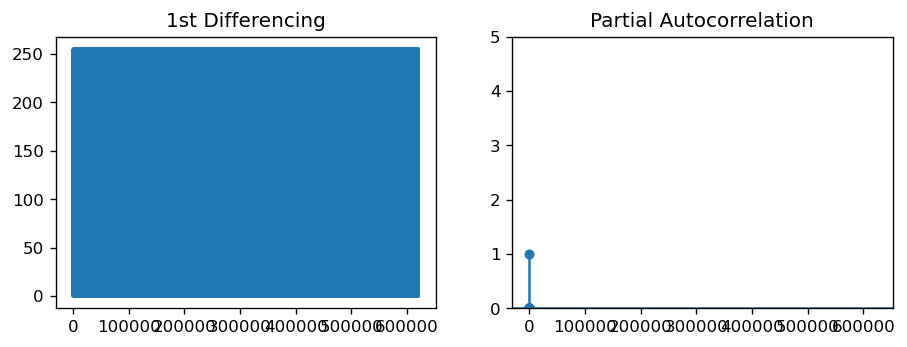

In [63]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df['concept:name_O_Returned'].diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(df['concept:name_O_Returned'].diff().dropna(), ax=axes[1])

plt.show()

# Find MA term

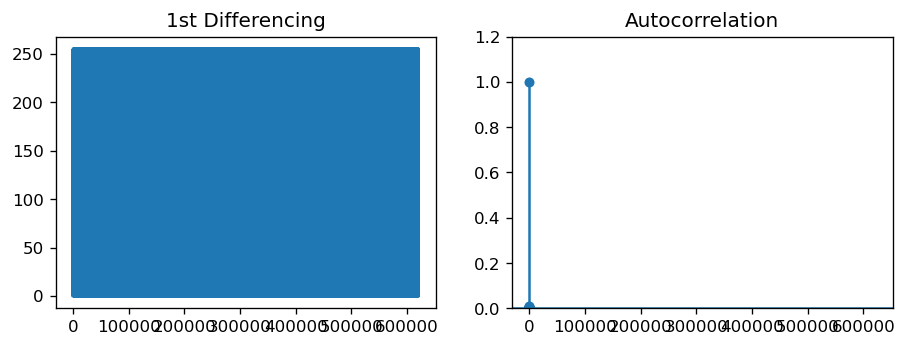

In [77]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df['concept:name_O_Returned'].diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(df['concept:name_O_Returned'].diff().dropna(), ax=axes[1])

plt.show()

# Make ARIMA Model

In [79]:
from statsmodels.tsa.arima_model import ARIMA

# 1,1,2 ARIMA Model
model = ARIMA(df['concept:name_O_Returned'], order=(1,1,2))
model_fit = model.fit(disp=0)
print(model_fit.summary())

C:\Users\20203721\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


MemoryError: Unable to allocate 2.81 TiB for an array with shape (621023, 621023) and data type float64